In [2]:
import pandas as pd
import datetime
import numpy as np

In [3]:
df=pd.read_csv('taxifare.csv')

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df.shape

(120000, 8)

In [6]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])-datetime.timedelta(hours=4)

In [7]:
df['Year']=df['pickup_datetime'].dt.year
df['Month']=df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hours']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute

In [8]:
df['mornight']=np.where(df['Hours']<12,0,1)

In [9]:
df.drop('pickup_datetime',axis=1,inplace=True)

In [10]:
df['fare_class'].unique()

array([0, 1], dtype=int64)

In [11]:
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
bsas = np.radians([40.730521, -73.992365])
paris = np.radians([40.744746,-73.975499])
result = haversine_distances([bsas, paris])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[0.        , 2.12631159],
       [2.12631159, 0.        ]])

In [12]:
def haversine(df):
    lat1= np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    #### Based on the formula  x1=drop_lat,x2=dropoff_long 
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [13]:
df['Total distance']=haversine(df)

In [14]:
df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace=True)

In [15]:
df.head()

,fare_amount,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,mornight,Total distance
0,6.5,0,1,2010,4,19,4,17,0,2.126312
1,6.9,0,1,2010,4,17,11,43,0,1.392307
2,10.1,1,2,2010,4,17,7,23,0,3.326763
3,8.9,0,1,2010,4,11,17,25,1,1.864129
4,19.7,1,1,2010,4,16,22,19,1,7.231321


In [16]:
#regression model
# x-dependent , y-independent
x=df.iloc[:,1:]
y=df.iloc[:,0]

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(x,y)

ExtraTreesRegressor()

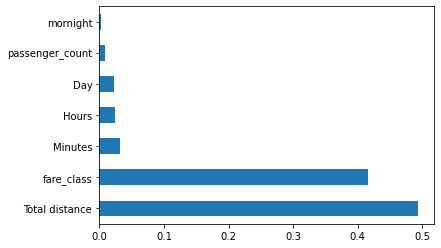

In [18]:
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [19]:
x.head()

,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,mornight,Total distance
0,0,1,2010,4,19,4,17,0,2.126312
1,0,1,2010,4,17,11,43,0,1.392307
2,1,2,2010,4,17,7,23,0,3.326763
3,0,1,2010,4,11,17,25,1,1.864129
4,1,1,2010,4,16,22,19,1,7.231321


In [20]:
y.head()

0     6.5
1     6.9
2    10.1
3     8.9
4    19.7
Name: fare_amount, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=100)

In [22]:
import xgboost
regressor=xgboost.XGBRegressor()
regressor.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_pred=regressor.predict(x_test)

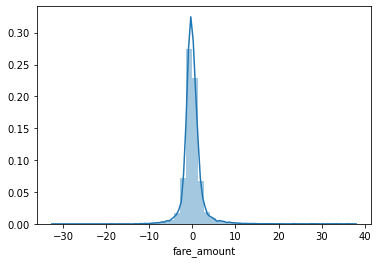

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(y_test-y_pred)

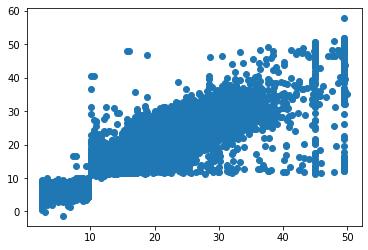

In [25]:
plt.scatter(y_test,y_pred)

In [26]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R square: 0.9400762644290246
MAE: 1.4025255039250852
MSE: 6.650561530702862
RMSE: 2.578868265480589


In [27]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [28]:
#Randomized Search CV

# Number of trees in Xgboost
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

In [29]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [30]:
regressor=xgboost.XGBRegressor()
xg_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter =5, cv = 10, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
xg_random.fit(x_train,y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 80.5min


In [ ]:
xg_random.best_params_

In [ ]:
y_pred=xg_random.predict(X_test)

In [ ]:
sns.distplot(y_test-y_pred)

In [ ]:
plt.scatter(y_test,y_pred)

In [ ]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))